In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
#plt.style.use("dark")

# Pierce Diode with Vlasov Equation using Upwind Finite Differences
One-dimensional Electrostatic Vlasov-Poisson Equation $$\frac{\partial f_\alpha}{\partial t}+v\frac{\partial f_\alpha}{\partial x}+\frac{q_\alpha E}{m_\alpha}\frac{\partial f_\alpha}{\partial v}=0$$
and $$\nabla\cdot E=4\pi\rho$$

[[ 0.   0.5  0.   0.   0.   0.   0.   0.   0.  -0.5]
 [-0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.   0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.5  0.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.   0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.5]
 [ 0.5  0.   0.   0.   0.   0.   0.   0.  -0.5  0. ]]


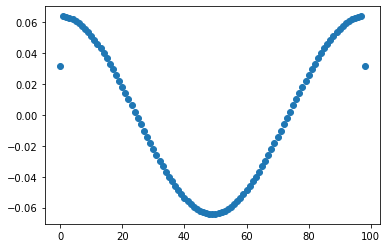

In [25]:

def laplace(n):
    matrix = np.diag(np.ones(n)*2)
    matrix += np.diag(np.ones(n-1)*-1, 1)
    matrix += np.diag(np.ones(n-1)*-1, -1)
    matrix[0,-1] = -1
    matrix[-1,0] = -1
    # matrix[0,0] = -1
    # matrix[-1,-1] = -1
    return matrix

def gradient(n):
    matrix = np.diag(np.ones(n)*0)
    matrix += np.diag(np.ones(n-1)*0.5, 1)
    matrix += np.diag(np.ones(n-1)*-0.5, -1)
    matrix[0,-1] = -0.5
    matrix[-1,0] = 0.5
    # matrix[0,0] = -1
    # matrix[-1,-1] = -1
    return matrix

def jacobi(A,b,N=25,x=None):
    """Solves the equation Ax=b via the Jacobi iterative method."""
    # Create an initial guess if needed                                                                                                                                                            
    if x is None:
        x = np.zeros(len(A[0]))

    # Create a vector of the diagonal elements of A                                                                                                                                                
    # and subtract them from A                                                                                                                                                                     
    D = np.diag(A)
    R = A - np.diagflat(D)

    # Iterate for N times                                                                                                                                                                          
    for i in range(N):
        x = (b - np.dot(R,x)) / D
    return x

plt.plot(gradient(99)@np.sin(np.linspace(0,2*np.pi,99)), "o")
print(gradient(10))

In [61]:
def solve_vlasov(vmax):
    nx = 256 # Steps in x-direction
    nv = 256 # Steps in v-direction
    maxiter = 30000 # Maximum amount of updates
    maxiter_jacobi = 100 # Jacobi steps to calculate electric potential
    plot_every = 1000 # Plot every n steps
    dt = 0.001 # Time stepping
    dx = 0.01 # Space stepping
    vmin = -vmax # Maximum velocity
    vmax = vmax # Minimum velocity
    q = -1
    vth = 0.2*vmax
    
    # Initialize empty phase space density
    f = np.zeros((nx, nv))
    # Get velocity values
    v = np.linspace(vmin, vmax, nv)
    dv = np.abs(v[1] - v[0]) # Velocity stepping
    # Matrix of Laplace operator for current size
    A = laplace(nx)
    print(dv)

    # Initialize empty array to store results
    result = np.zeros((maxiter//plot_every, nx, nv))
    
    
    for i in range(nv):
        
        f[:, i] = np.exp(-v[i]**2/vth**2)
        
    mask = np.random.normal(0.6,0.005, size=nv)*nv
    mask = np.unique(mask.astype("int"))
    f[:,int(nv*0.6)] += 1 + np.random.uniform(0,0.1, nx)
    
    # Main loop
    for it in tqdm(range(maxiter)):
        # Set patticle stream at x=0 and v=normal(vmean)
        #f[0,int(nv*np.clip(np.random.normal(0.6,0.005),0,1))-1] += 1
        #f[5,int(nv*0.6)] += 1


        # Upwind update in x-direction
        # Case v > 0:
        f[:,:nv//2] -= dt/dx * (np.roll(f[:,:nv//2], -1, axis=0) - f[:,:nv//2])*v[:nv//2]
        # Case v <= 0:
        f[:,nv//2:] -= dt/dx * (f[:,nv//2:] - np.roll(f[:,nv//2:], 1, axis=0))*v[nv//2:]
        
        f[1,:] = f[-1,:]
        f[-2,:] = f[0,:]

        # Calculate charge density from phase space density
        rho = q*np.sum(f, axis=1)
        # Subtract Ion background
        rho = rho + np.mean(rho)

        # Calculate electric potential from charge density
        phi = jacobi(A, rho, N=maxiter_jacobi)

        # Calculate electric field
        E = - gradient(nx)@phi
        
        E[-1] = E[1]
        E[0] = E[-2]

        # Upwind update in v-direction
        E_mask = E > 0

        # Dirty but effective separation of case E > 0 and E <= 0
        f_up =  f[E_mask,:] - f[np.roll(E_mask, 1),:]
        f_down = f[np.roll(~E_mask, -1),:] - f[~E_mask,:]

        # Perform upwind update 
        f[E_mask,:] -= dt/dv*f_up*E[E_mask,np.newaxis]
        f[~E_mask,:] -= dt/dv*f_down*E[~E_mask, np.newaxis]

        # Save current state every n iterations
        if it%plot_every==0:
            result[it//plot_every] = f

            fig, ax = plt.subplots(2,2, figsize=(15,10))

            fig.suptitle("Pierce Diode Vlasov Equation at $t = {}$".format(maxiter*dt))
            im = ax[0,0].imshow(result[it//plot_every].T, cmap="magma",aspect="auto", origin="lower", extent=[0, nx, vmin, vmax])
            ax[0,0].set_xlabel("Position $x$")
            ax[0,0].set_ylabel("Velocity $v$")
            ax[0,0].grid(False)
            plt.colorbar(im, ax=ax[0,0], label="Phase space density $f(x,v,t)$")

            ax[1,0].plot(result[it//plot_every].sum(axis=1)[2:-2], "o")
            ax[1,0].set_xlabel("Position $x$")
            ax[1,0].set_ylabel("Charge Density $\\rho(x)$")

            ax[0,1].plot(result[it//plot_every].sum(axis=0)[2:-2], "o")
            ax[0,1].set_xlabel("Velocity $v$")
            ax[0,1].set_ylabel("Charge Density $\\rho(v)$")

            ax[1,1].plot(E[2:-2], "o")
            ax[1,1].set_ylabel("Electric Field $E(x)$")
            ax[1,1].set_xlabel("Position $x$")
            plt.show()     

  0%|                                                                                        | 0/30000 [00:00<?, ?it/s]

0.015686274509803866


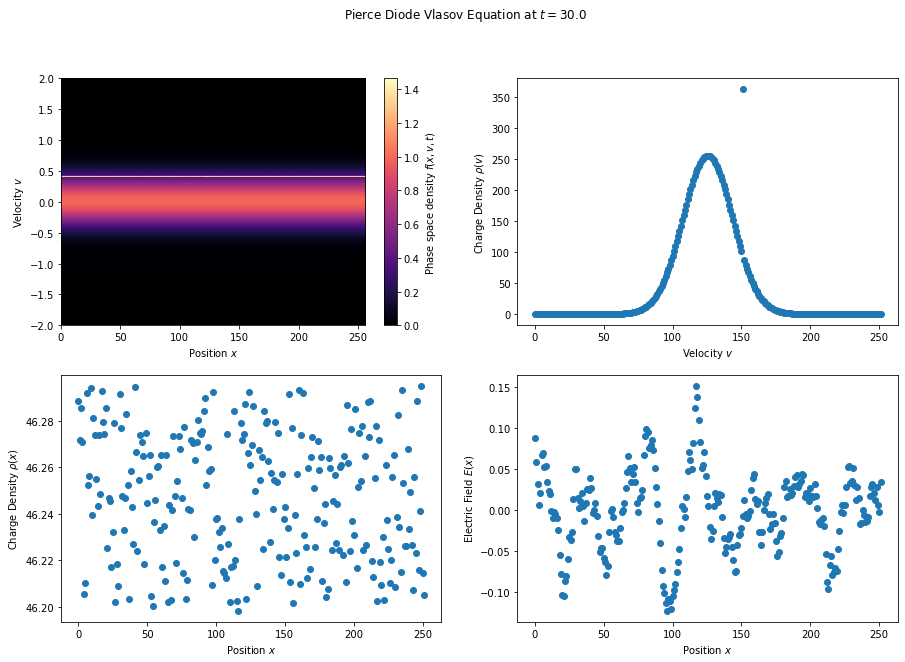

  3%|██▌                                                                          | 985/30000 [00:08<02:48, 172.27it/s]

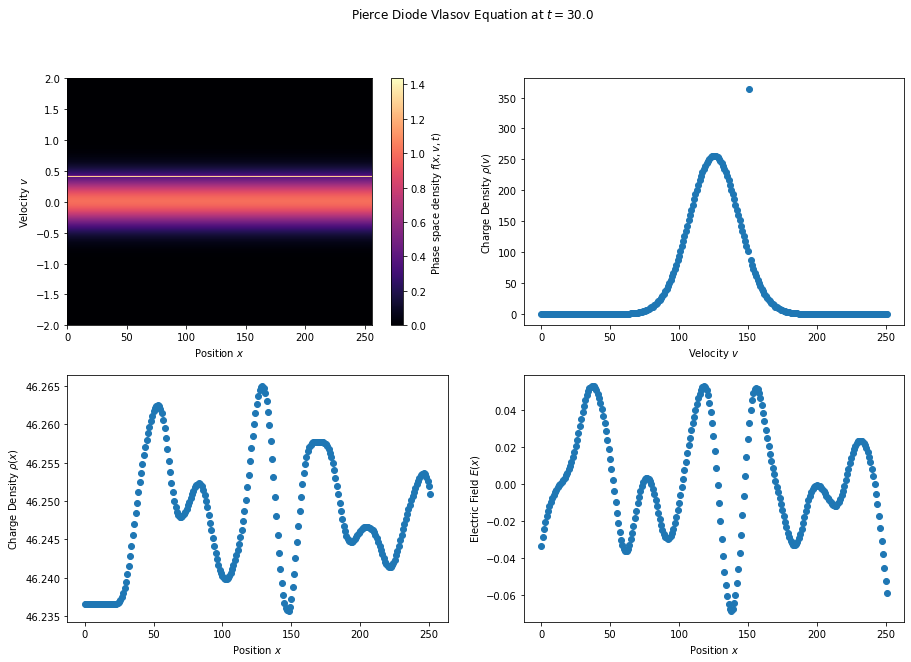

  7%|█████                                                                       | 1985/30000 [00:16<02:33, 182.95it/s]

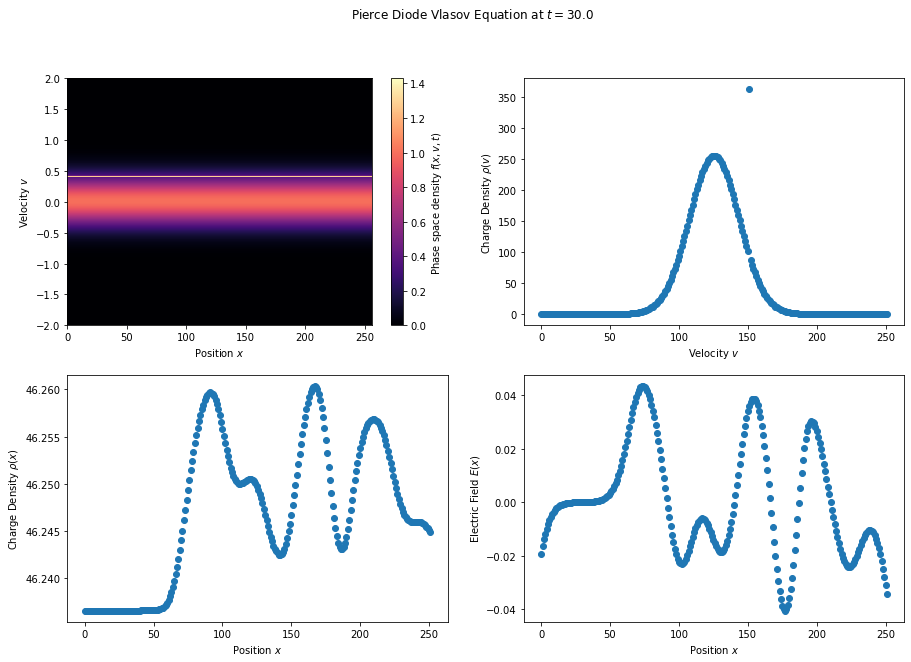

 10%|███████▌                                                                    | 2985/30000 [00:27<03:35, 125.52it/s]

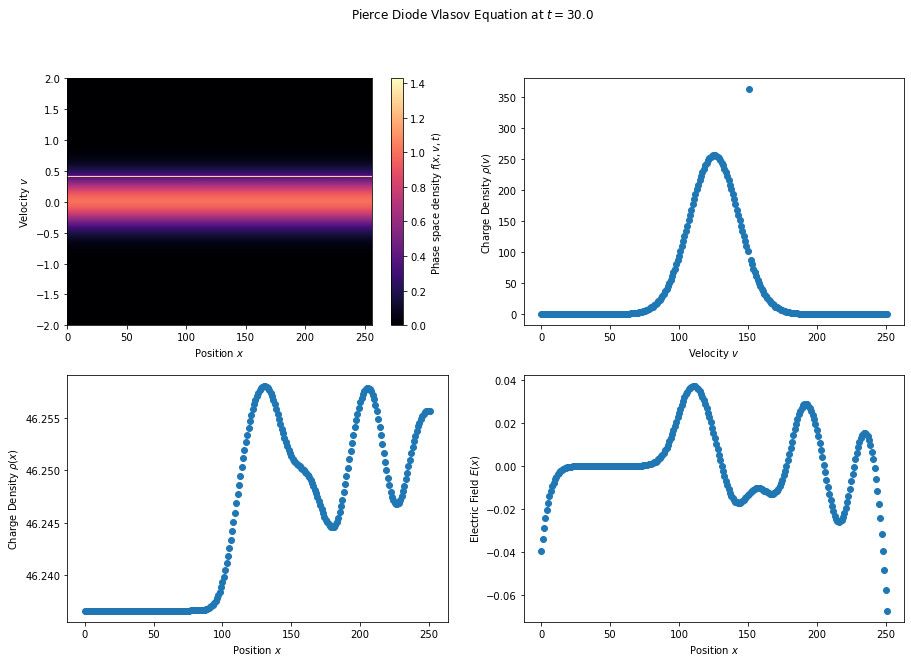

 13%|██████████                                                                  | 3993/30000 [00:35<02:16, 190.99it/s]

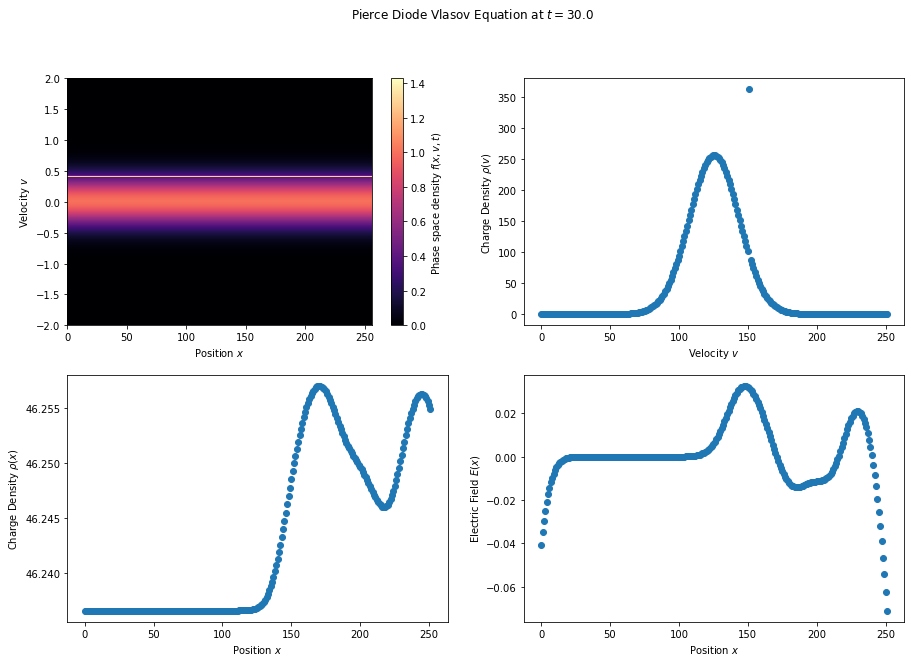

 17%|████████████▋                                                               | 4985/30000 [00:42<02:30, 166.57it/s]

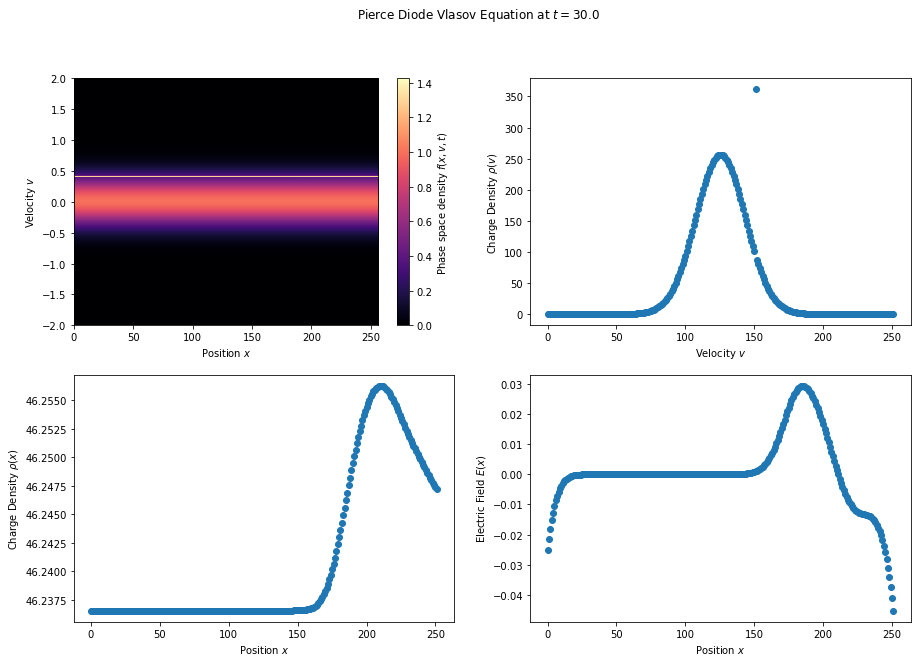

 20%|███████████████▎                                                             | 5989/30000 [00:59<11:09, 35.88it/s]

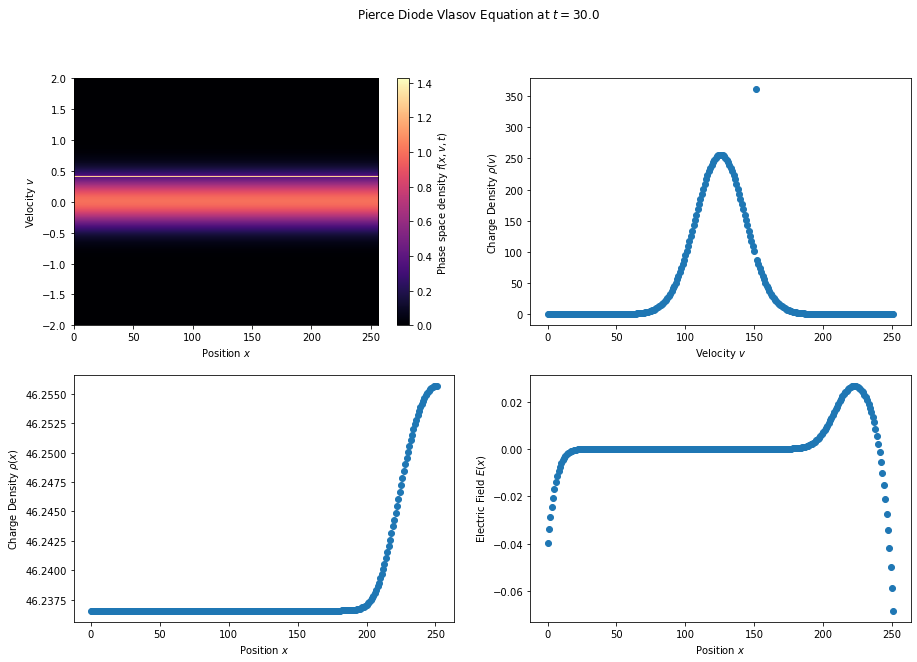

 23%|█████████████████▋                                                          | 6987/30000 [01:06<02:10, 176.13it/s]

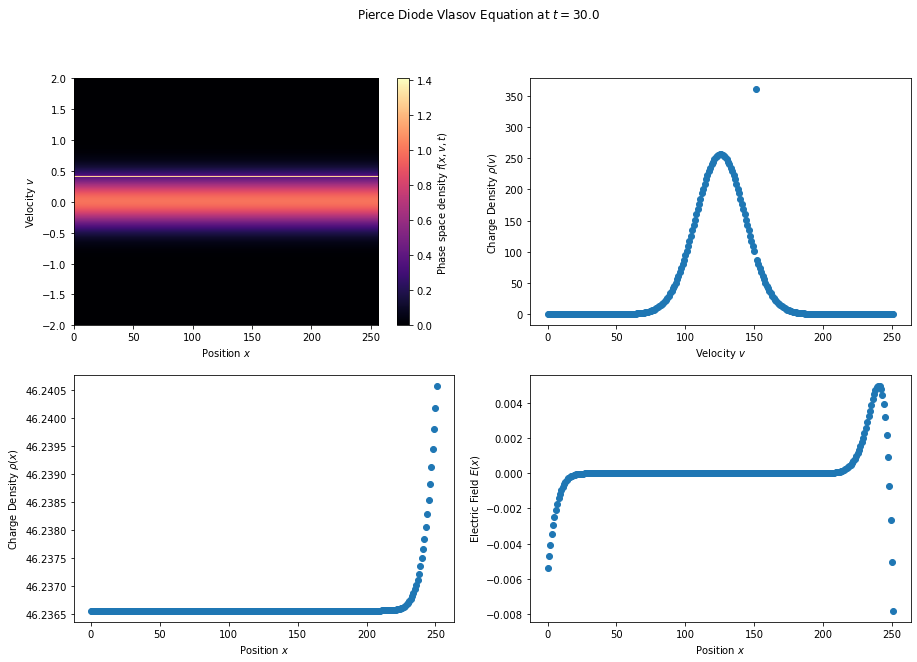

 27%|████████████████████▌                                                        | 7993/30000 [01:17<05:15, 69.67it/s]

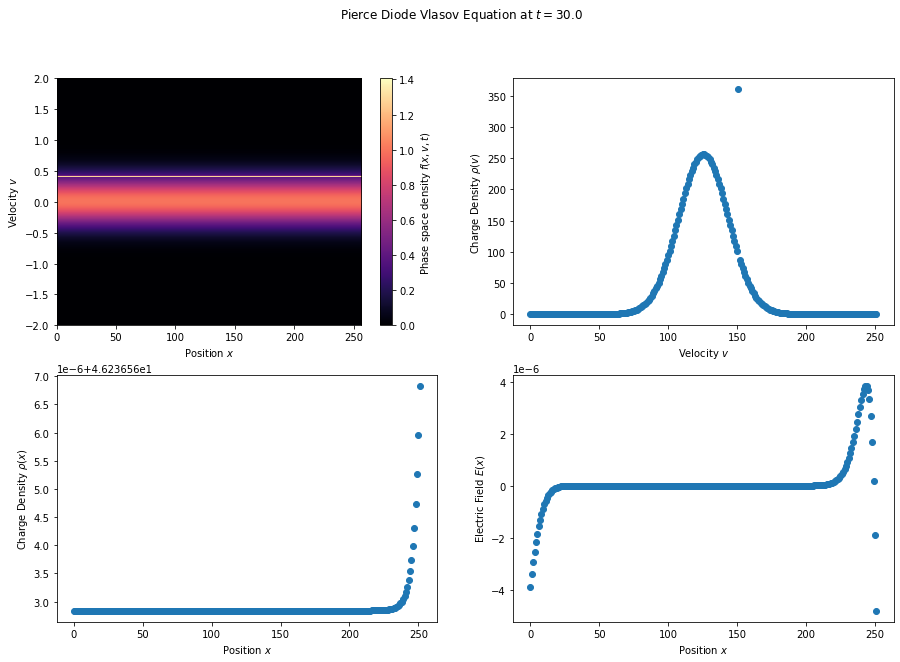

 30%|██████████████████████▊                                                     | 9000/30000 [01:25<02:46, 126.32it/s]

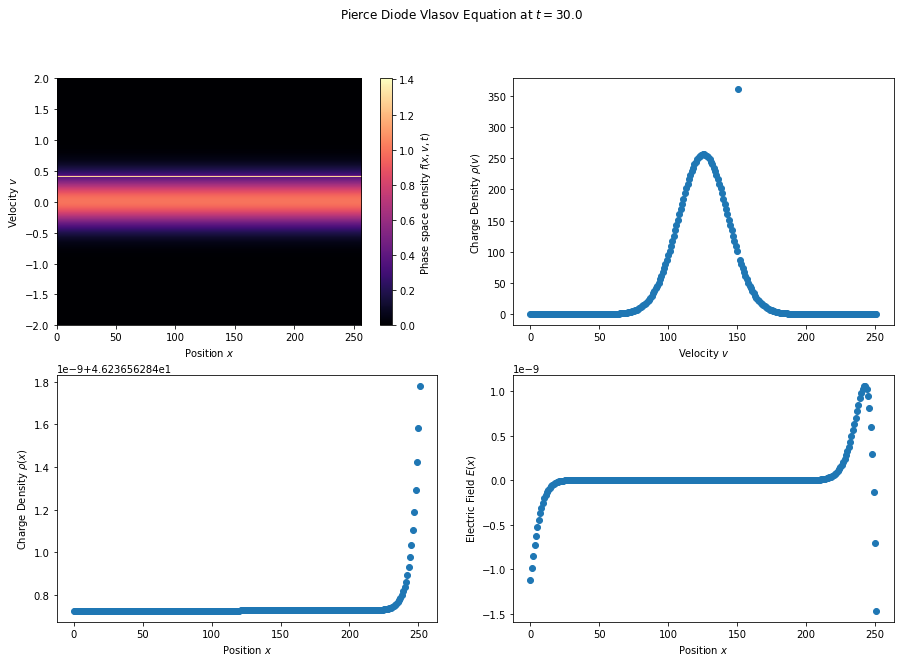

 33%|█████████████████████████▎                                                  | 9998/30000 [01:34<01:45, 190.20it/s]

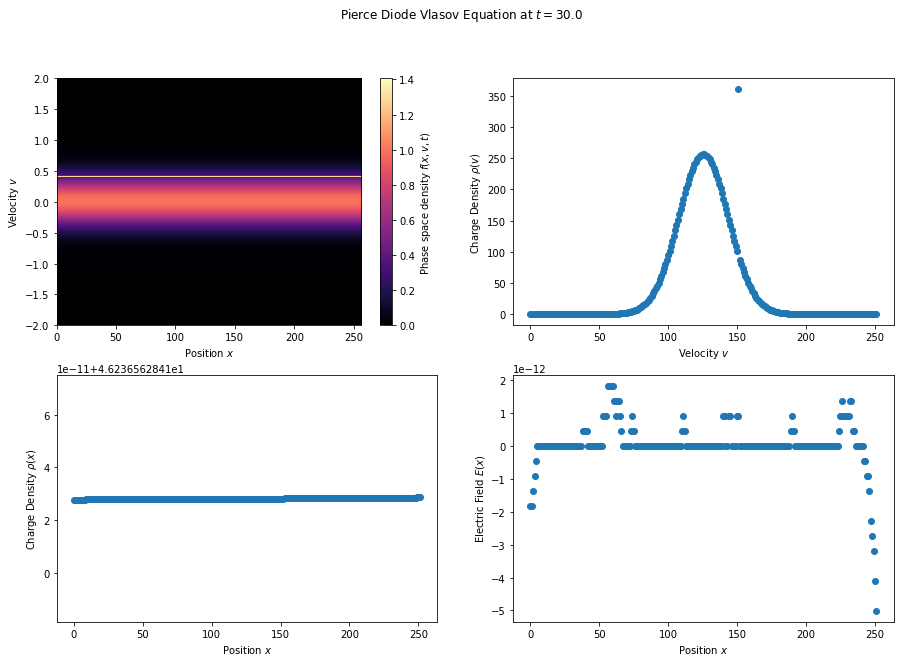

 37%|███████████████████████████▊                                                | 10996/30000 [01:44<04:10, 75.77it/s]

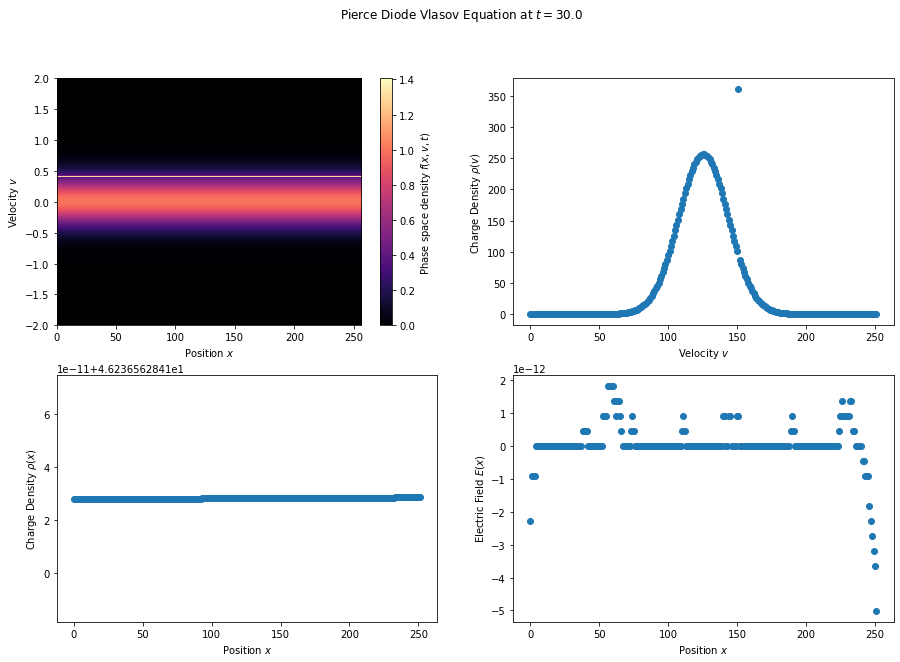

 40%|█████████████████████████████▉                                             | 11999/30000 [01:52<02:11, 136.82it/s]

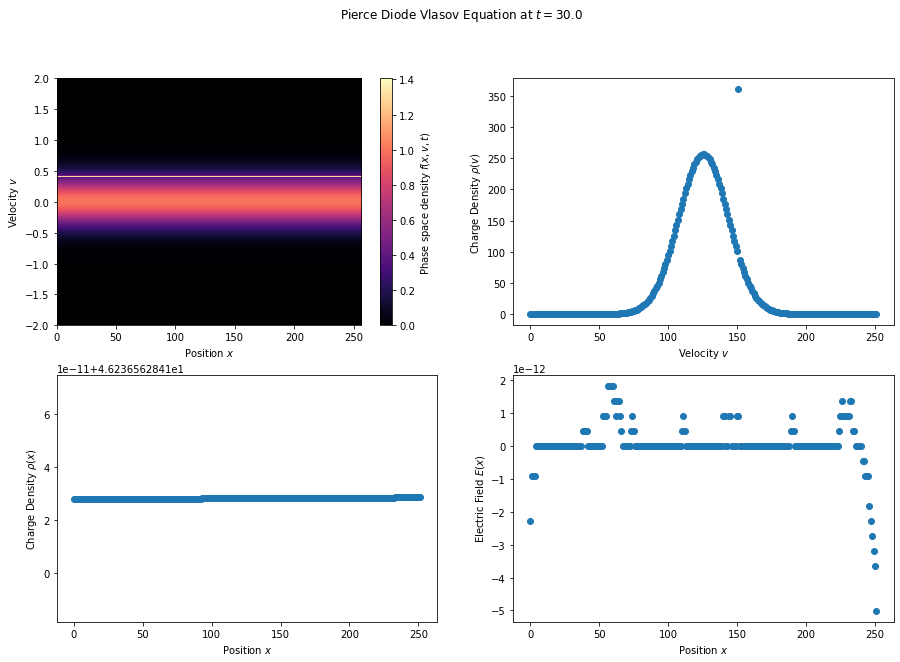

 43%|████████████████████████████████▉                                           | 12987/30000 [02:02<02:52, 98.74it/s]

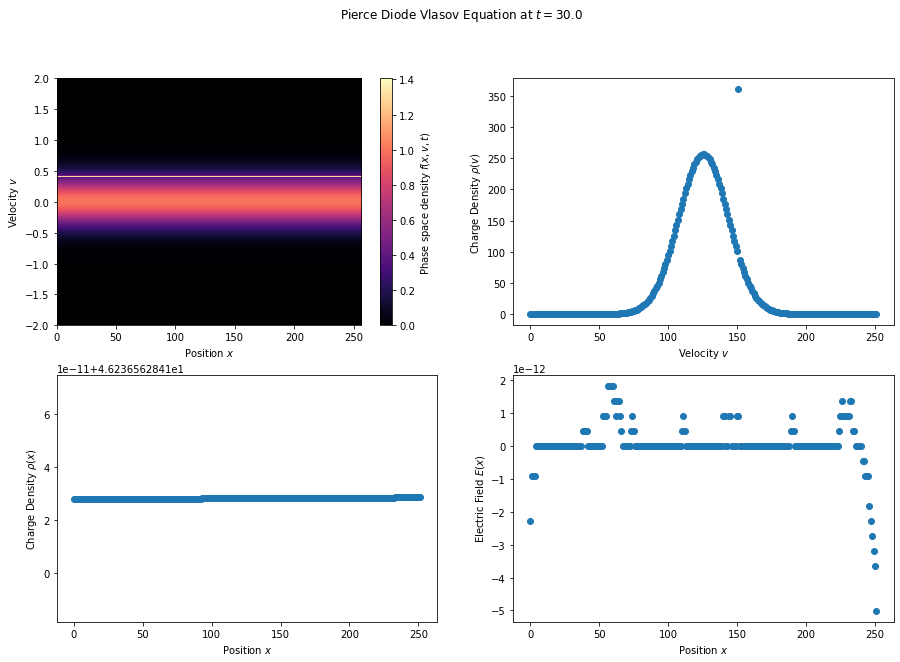

 47%|██████████████████████████████████▉                                        | 13989/30000 [02:12<01:40, 158.73it/s]

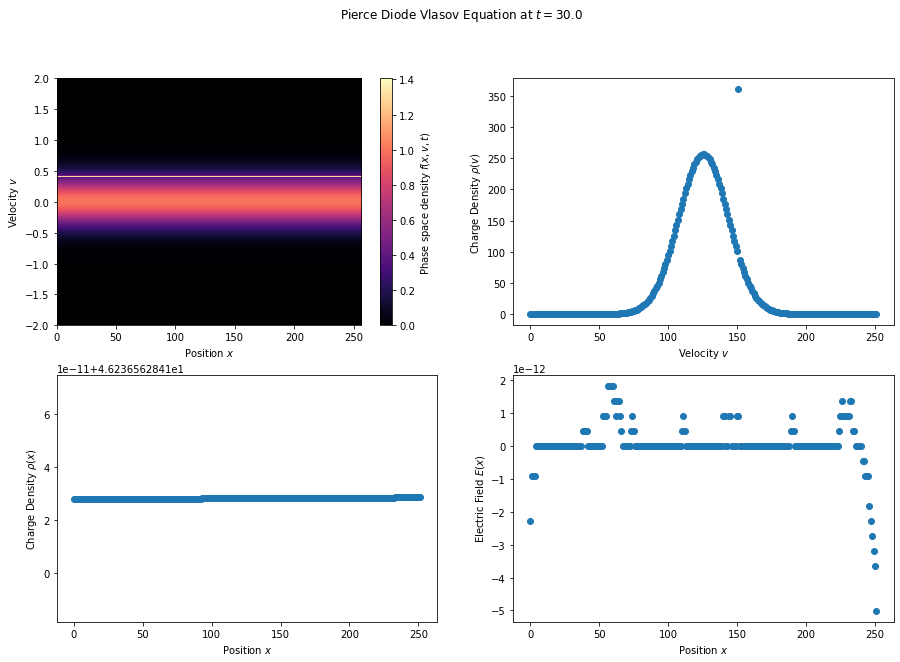

 50%|█████████████████████████████████████▍                                     | 14993/30000 [02:22<01:30, 166.65it/s]

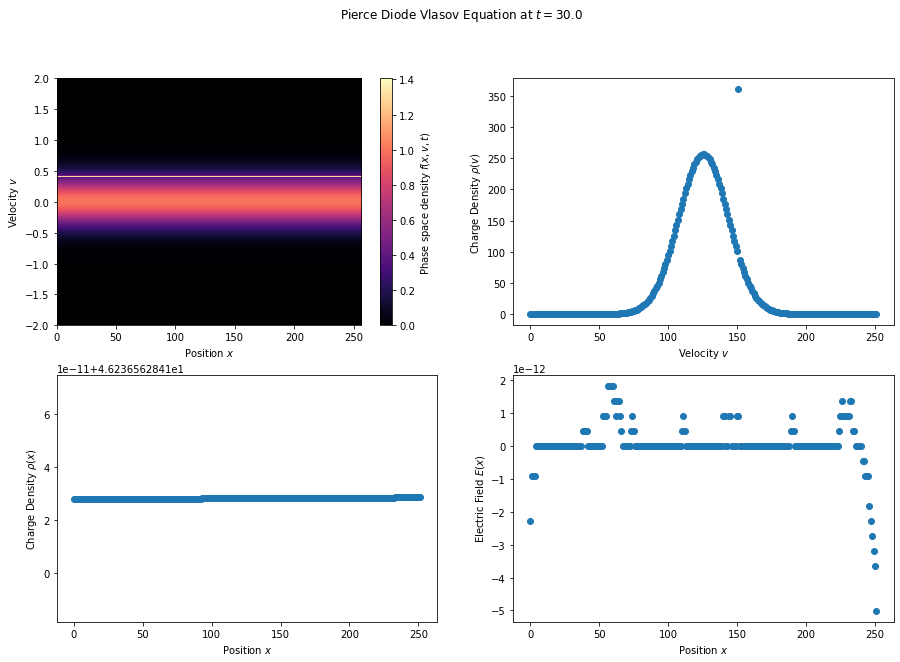

 53%|███████████████████████████████████████▉                                   | 15994/30000 [02:29<01:20, 174.07it/s]

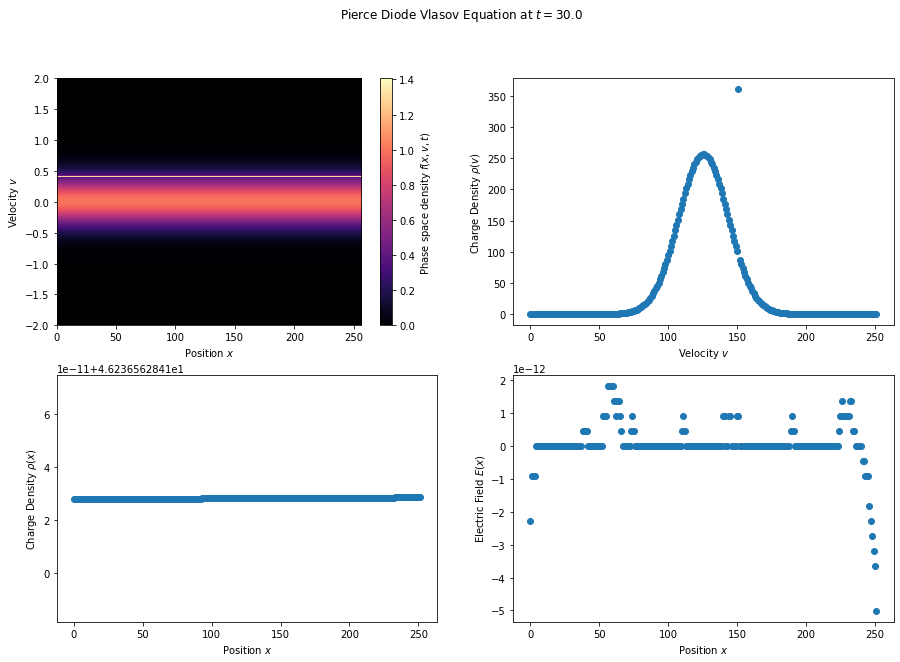

 57%|██████████████████████████████████████████▍                                | 16989/30000 [02:38<01:12, 178.96it/s]

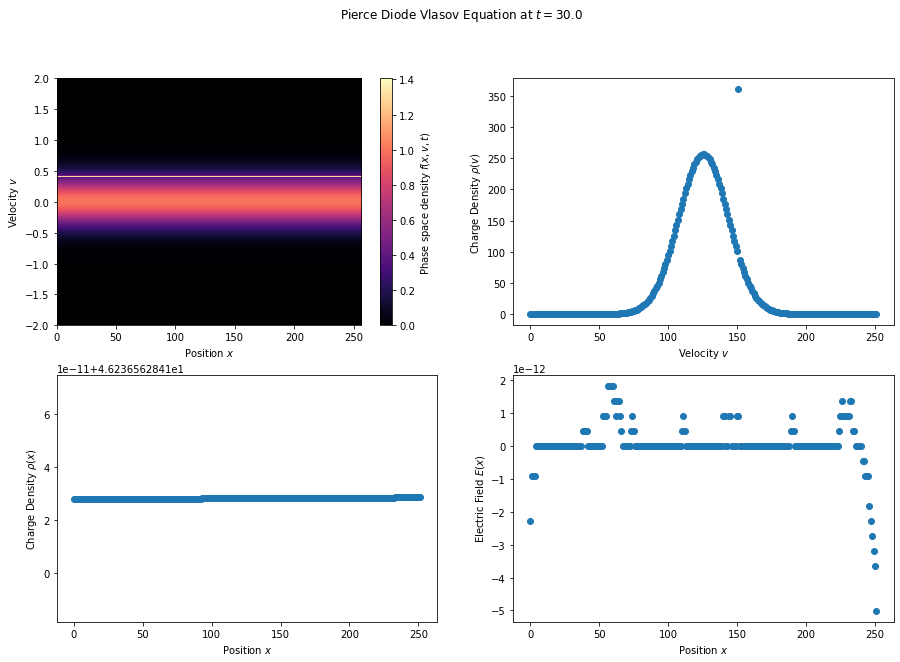

 60%|████████████████████████████████████████████▉                              | 17983/30000 [02:46<01:11, 168.50it/s]

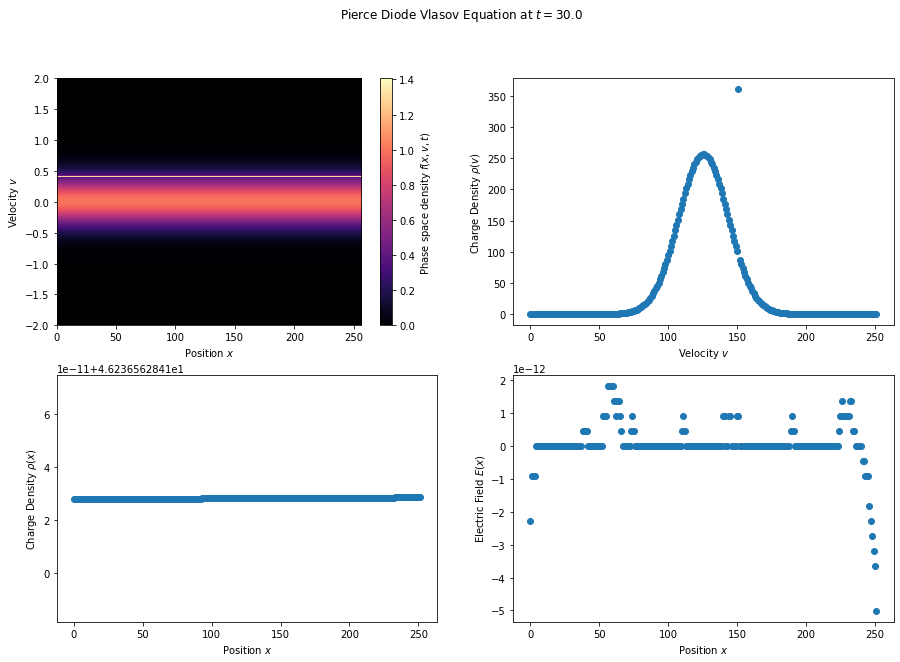

 63%|███████████████████████████████████████████████▍                           | 18998/30000 [03:00<01:06, 165.96it/s]

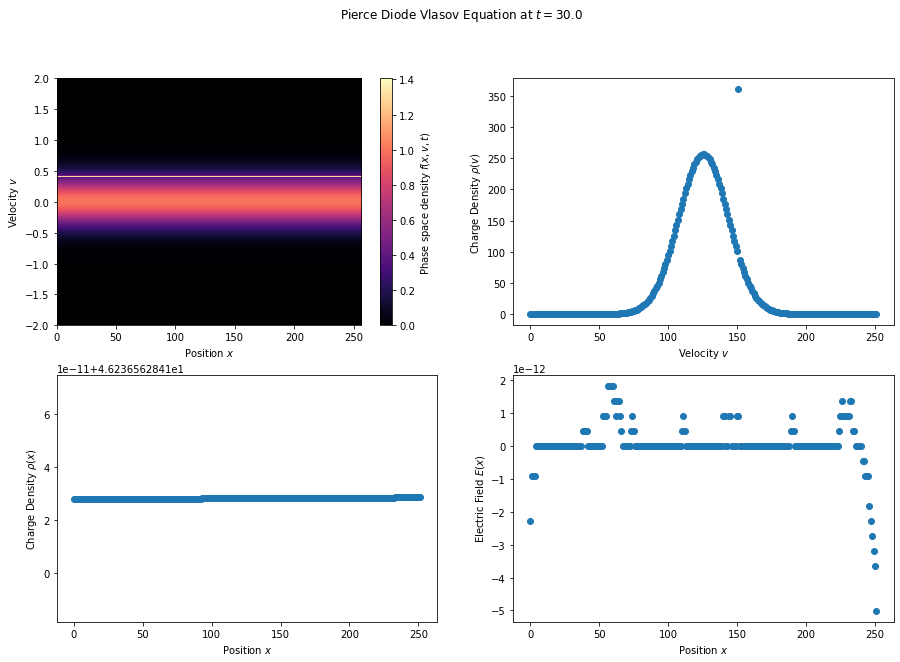

 67%|█████████████████████████████████████████████████▉                         | 19984/30000 [03:07<01:04, 155.45it/s]

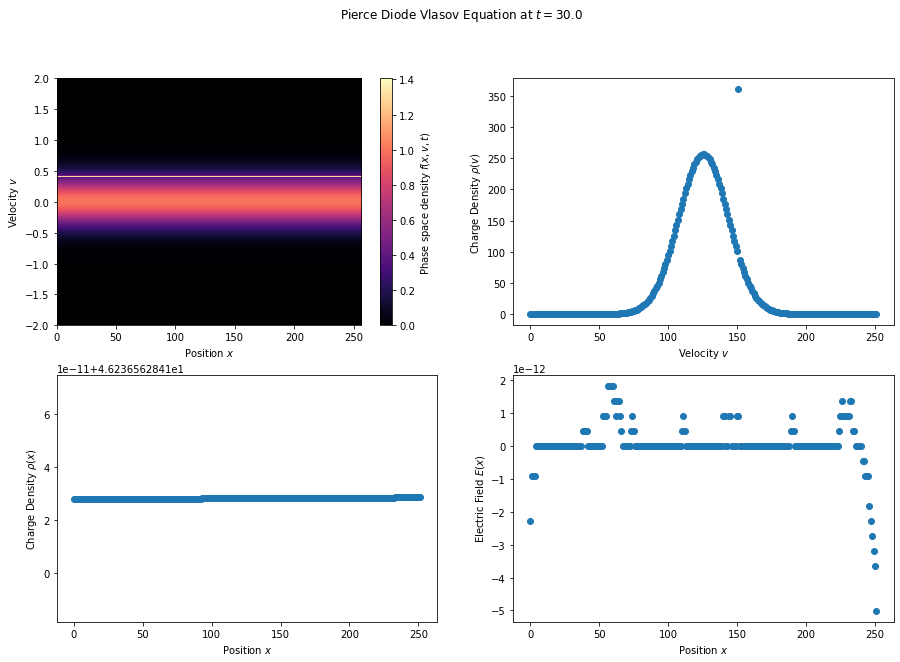

 70%|████████████████████████████████████████████████████▍                      | 20999/30000 [03:16<00:56, 159.46it/s]

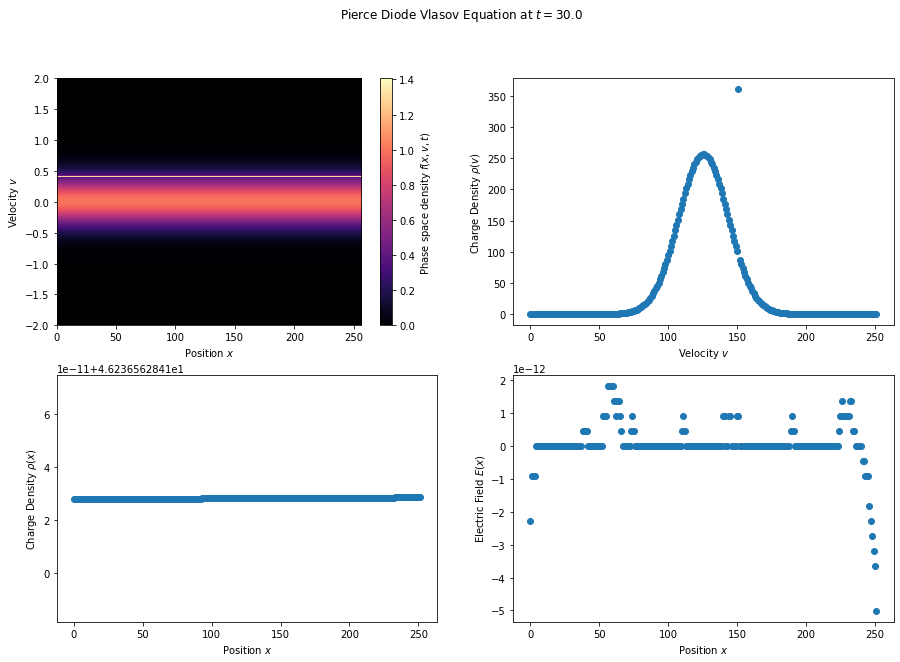

 73%|██████████████████████████████████████████████████████▉                    | 21994/30000 [03:24<00:59, 135.03it/s]

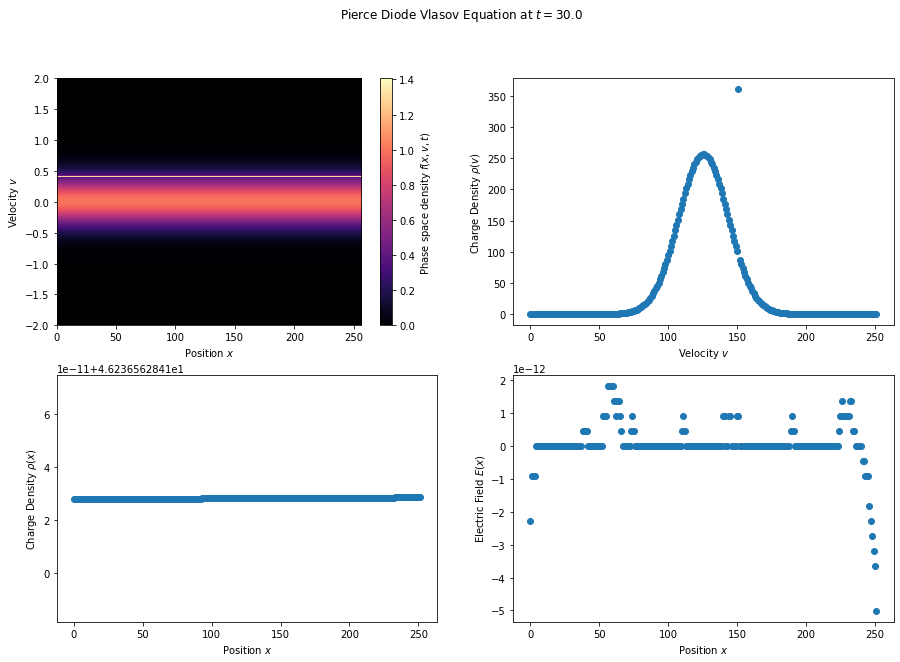

 74%|███████████████████████████████████████████████████████▎                   | 22103/30000 [03:27<01:14, 106.62it/s]


KeyboardInterrupt: 

In [64]:
solve_vlasov(2)

100%|██████████| 3000/3000 [00:11<00:00, 266.47it/s]


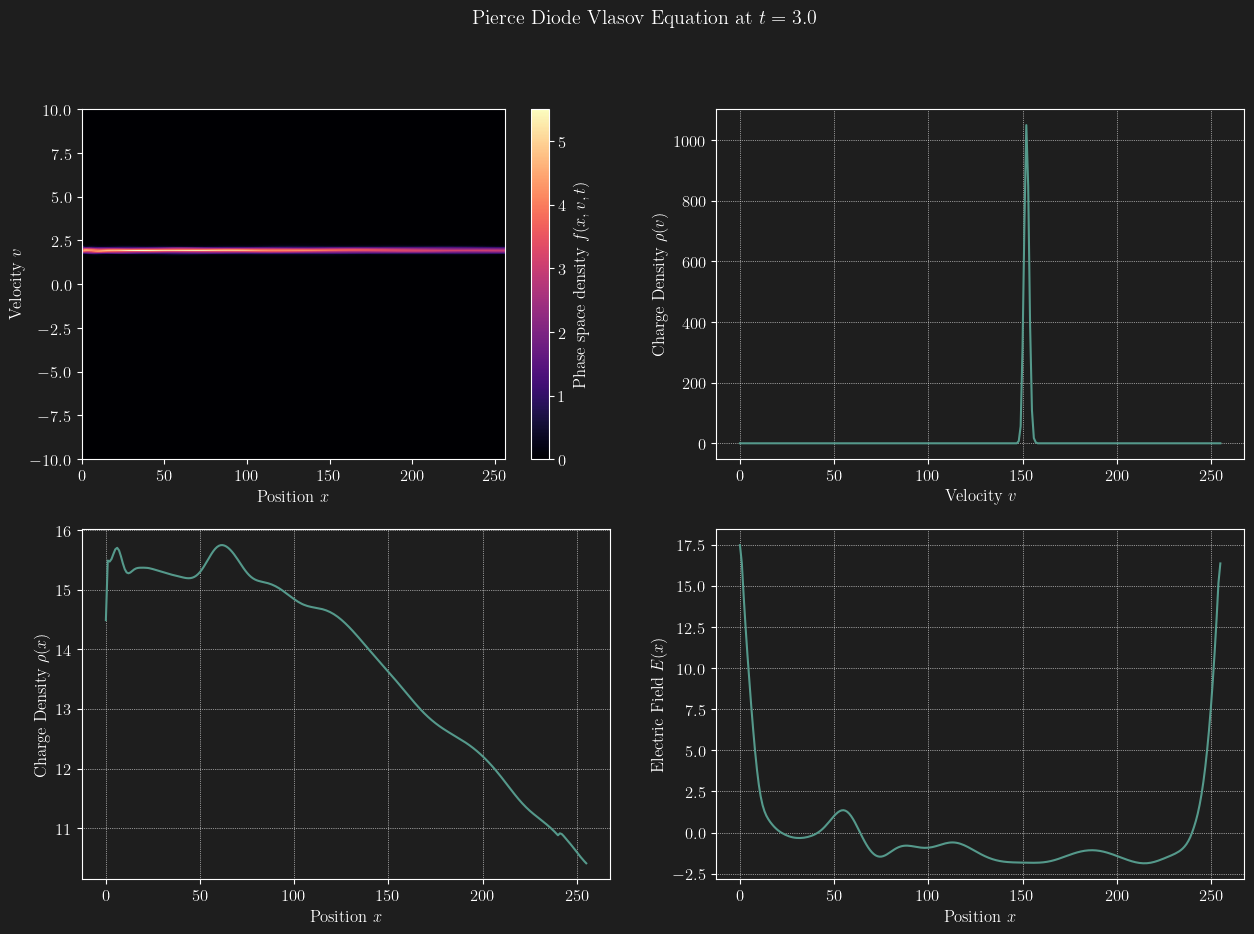

In [36]:
solve_vlasov(10)

  0%|                                                                                        | 0/30000 [00:00<?, ?it/s]

0.15686274509803866


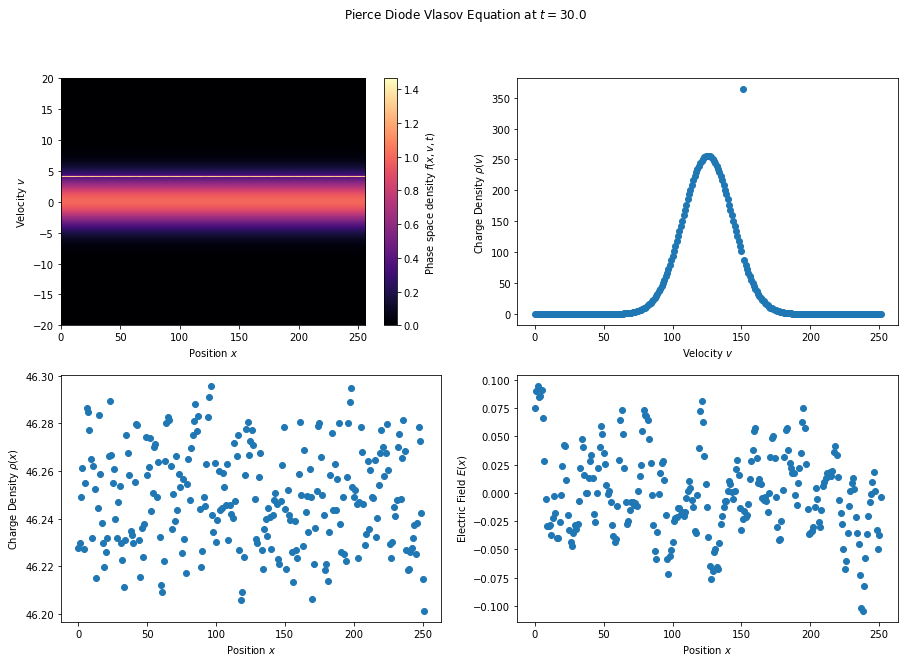

  3%|██▌                                                                          | 990/30000 [00:08<02:35, 186.90it/s]

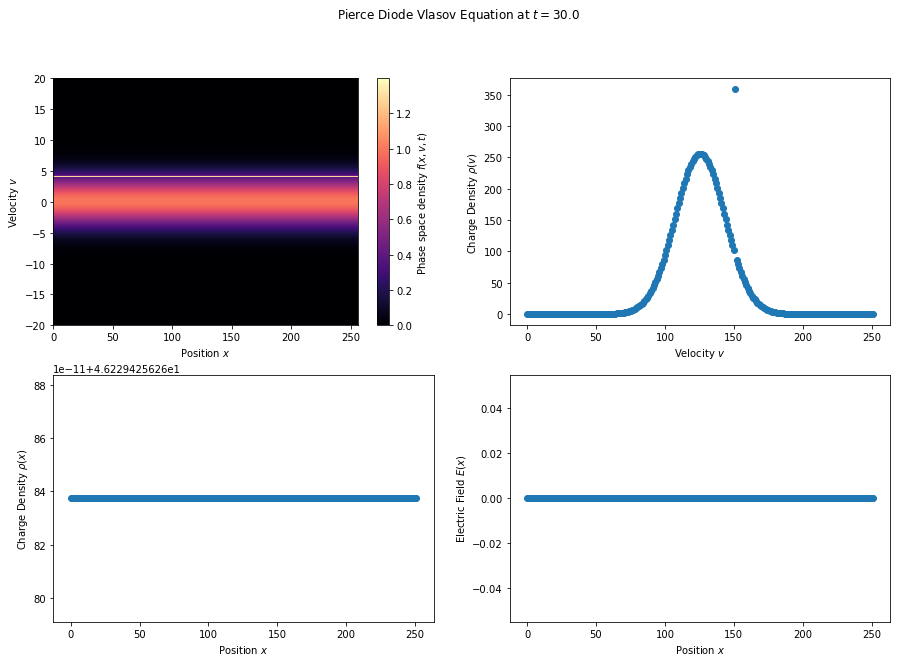

  7%|█████▏                                                                       | 2000/30000 [00:15<04:44, 98.43it/s]

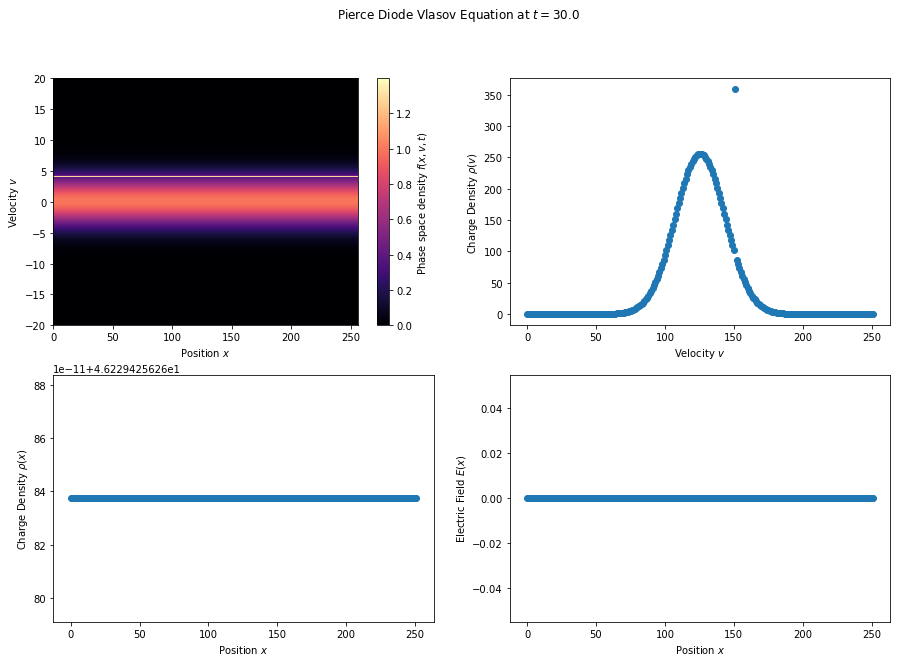

  9%|██████▋                                                                     | 2643/30000 [00:26<04:33, 100.04it/s]


KeyboardInterrupt: 

In [63]:
solve_vlasov(20)

In [7]:
def make_gif(data, gifpath, fps=25, cmap="twilight", vmin=-0.02, vmax=0.02):
    import os
    import glob
    import imageio
    import matplotlib.pyplot as plt
    import shutil
    import tqdm
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    if "temp" not in os.listdir("/tmp/"):
        os.mkdir("/tmp/temp")
    zfill_param = int(np.ceil(np.log10(len(data))))

    print("Save Images...")
    for i in tqdm.tqdm(range(len(data))):
        # plt.plot(0,0,"o", color="black", s=)
        plt.plot(data[i], "-")
        # plt.xlim(-30, 100)
        # plt.ylim(-30, 30)
        plt.savefig("/tmp/temp/pic" + str(i).zfill(zfill_param) + ".png")
        plt.clf()
    print("Done.")

    print("Make Gif...")
    # for filename in sorted(glob.glob("temp/pic*")):
    images = [imageio.imread(filename)
              for filename in tqdm.tqdm(sorted(glob.glob("/tmp/temp/pic*")))]
    imageio.mimsave(gifpath, images, fps=fps)
    shutil.rmtree("/tmp/temp")
    print("Done.")

In [8]:
make_gif(result.sum(axis=2), "plasma.gif")

Save Images...


100%|██████████| 300/300 [00:56<00:00,  5.31it/s]


Done.
Make Gif...


100%|██████████| 300/300 [00:01<00:00, 193.04it/s]


Done.


<Figure size 640x480 with 0 Axes>

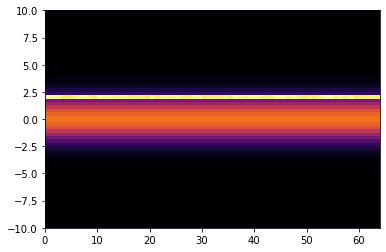

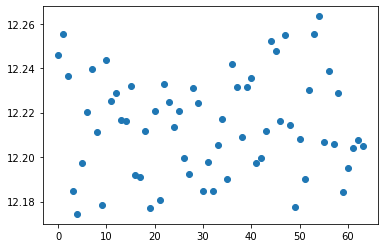

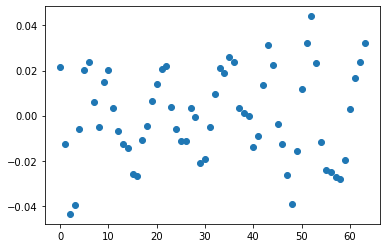

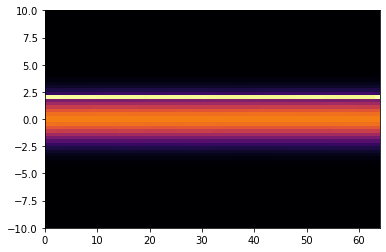

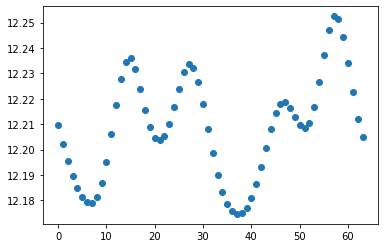

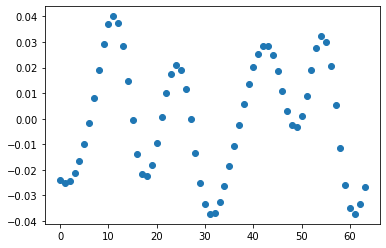

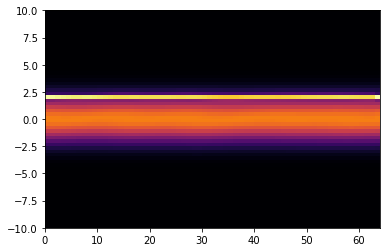

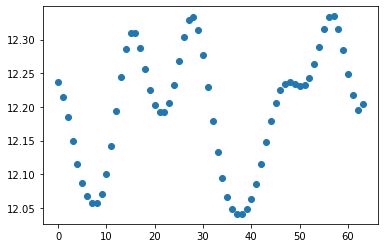

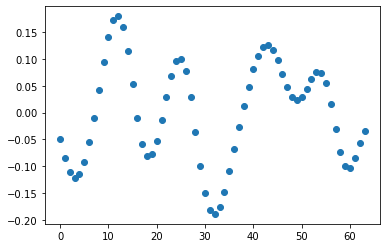

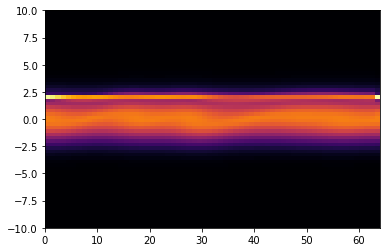

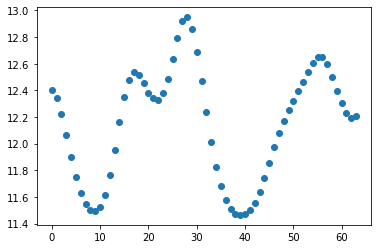

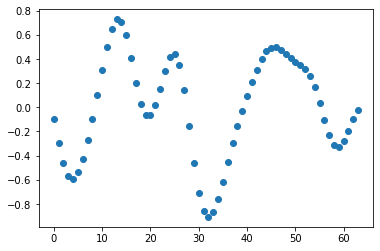

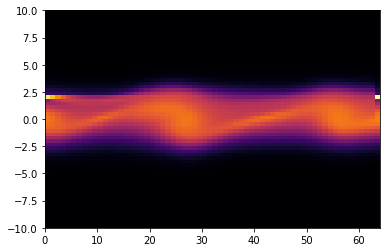

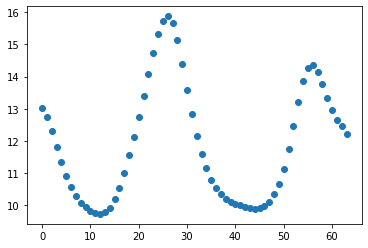

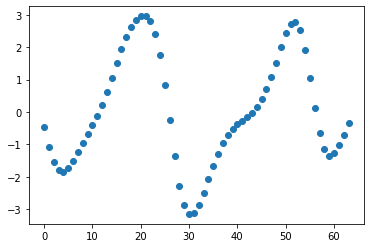

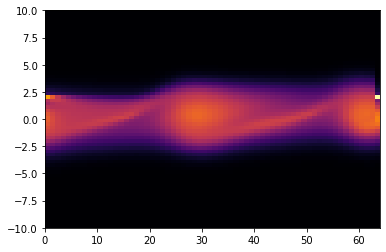

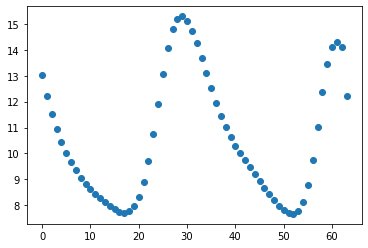

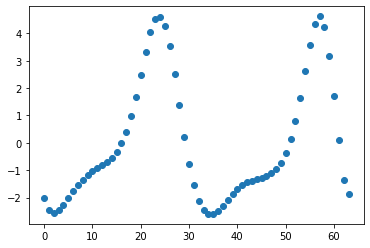

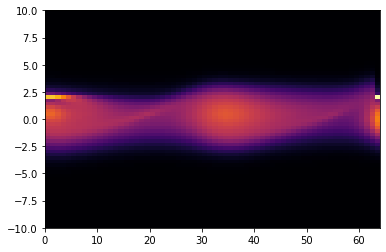

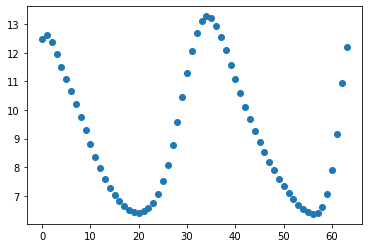

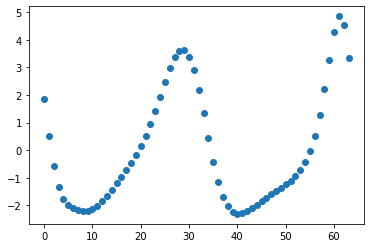

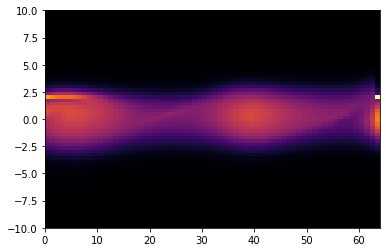

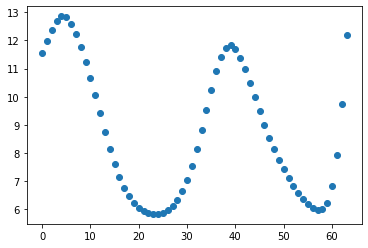

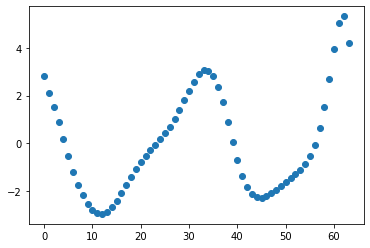

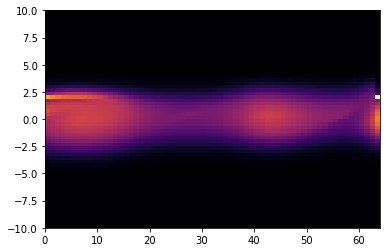

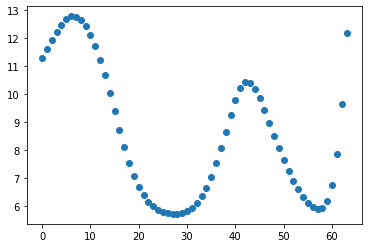

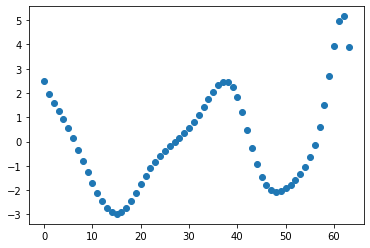

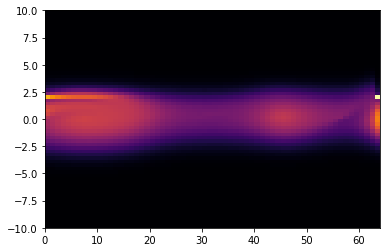

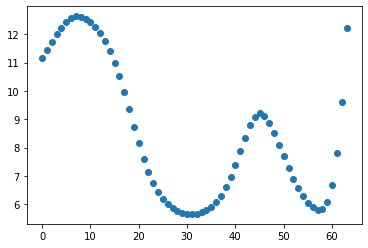

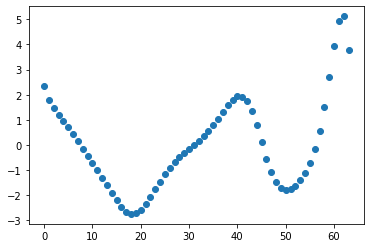

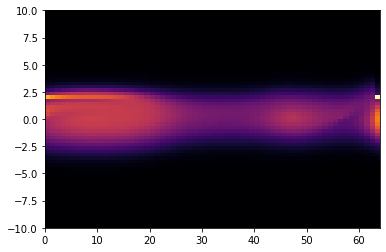

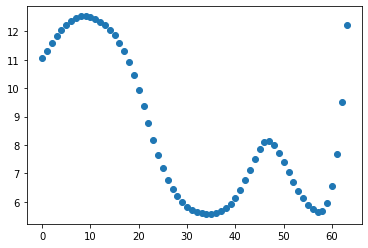

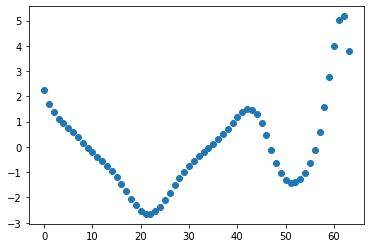

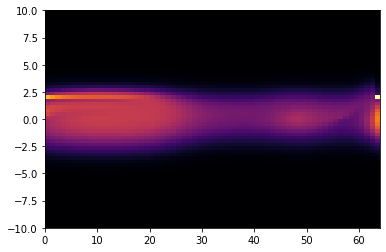

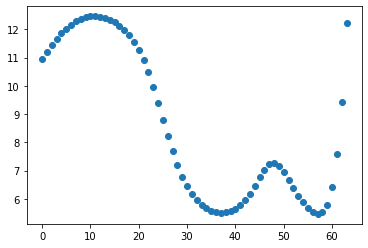

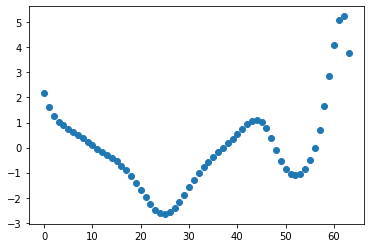

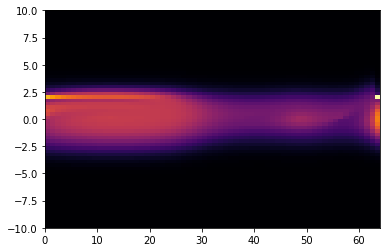

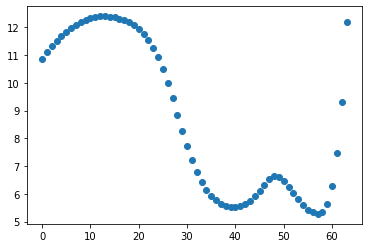

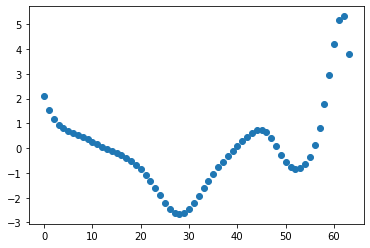

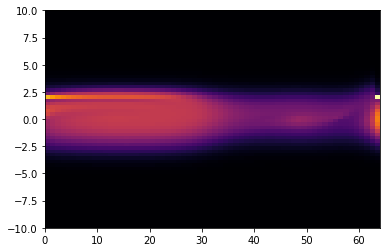

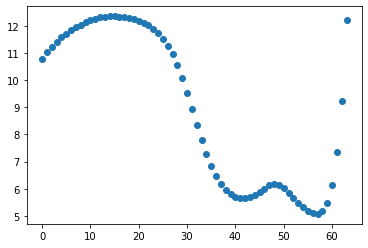

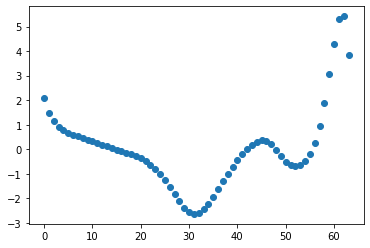

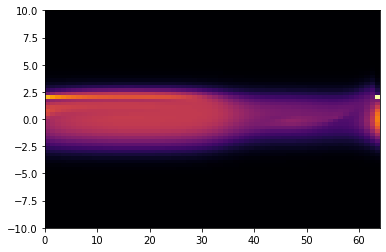

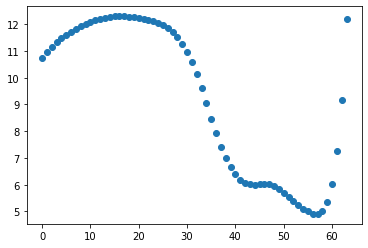

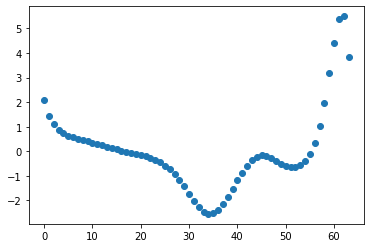

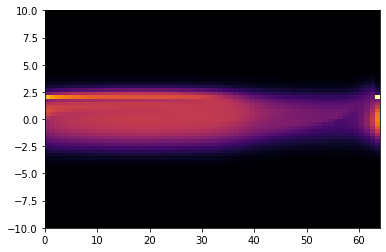

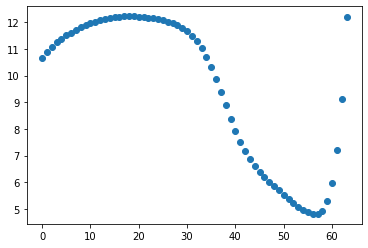

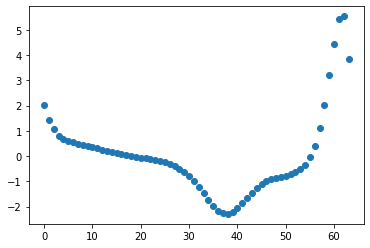

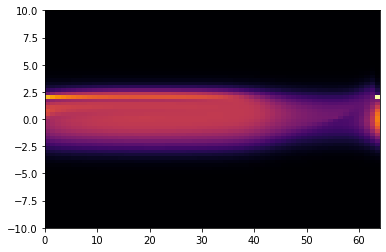

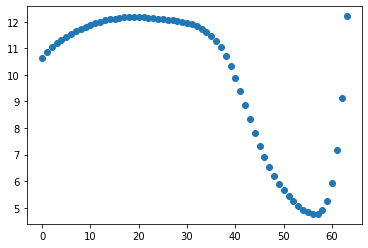

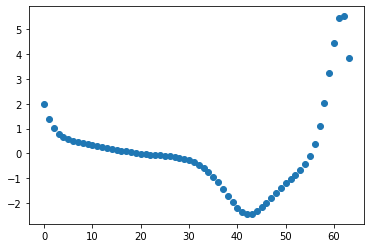

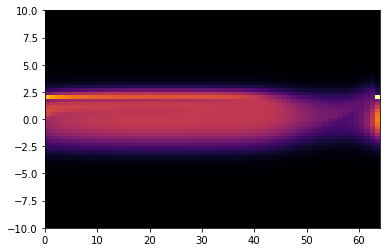

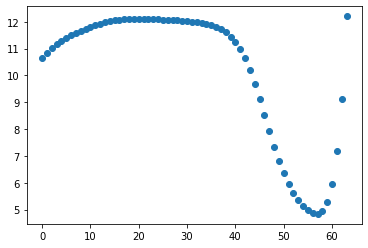

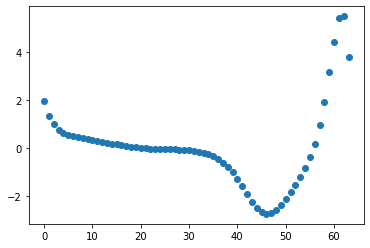

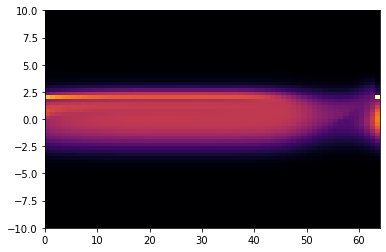

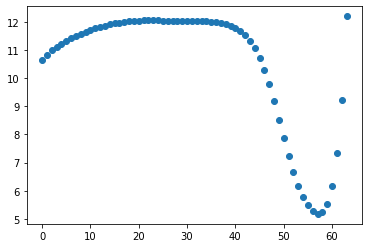

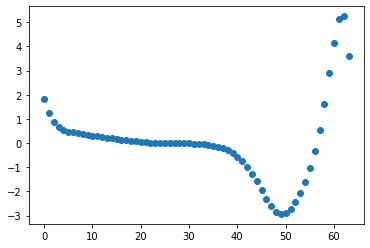

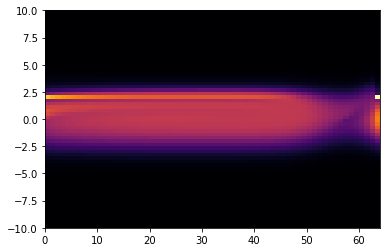

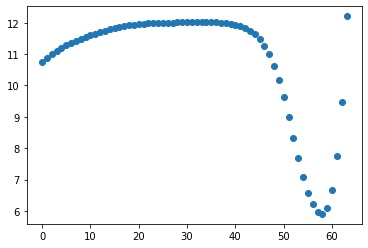

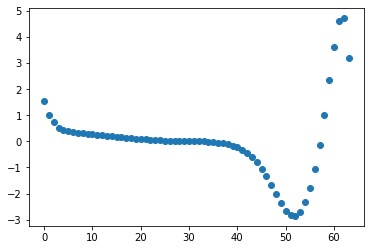

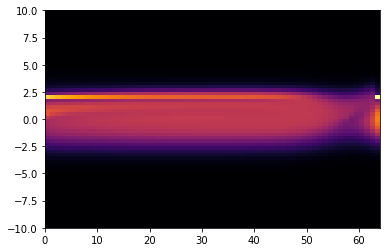

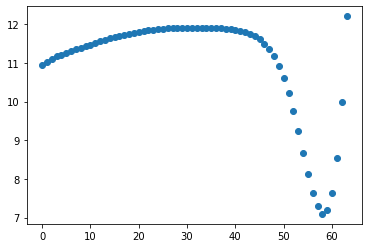

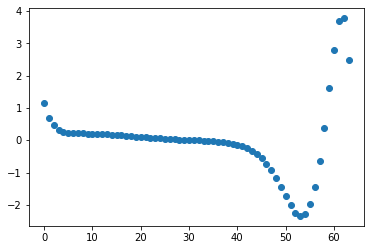

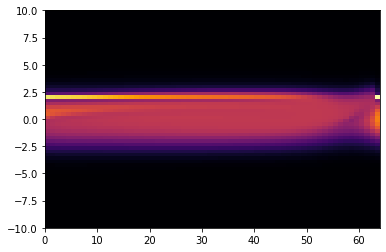

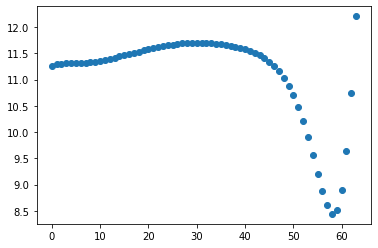

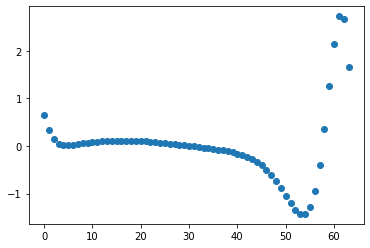

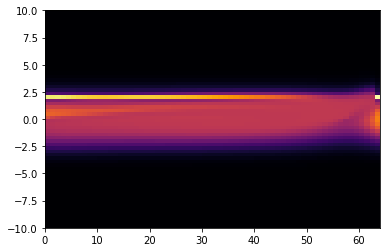

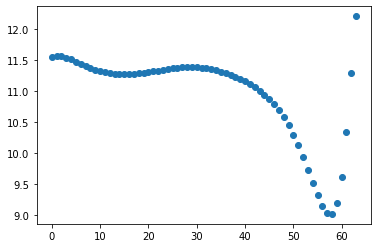

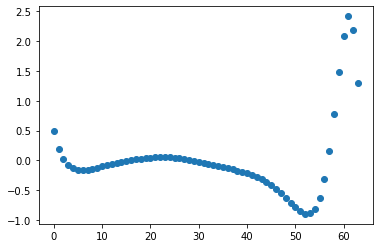

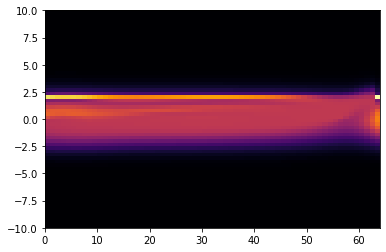

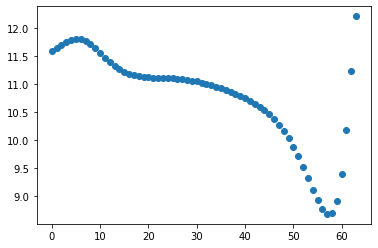

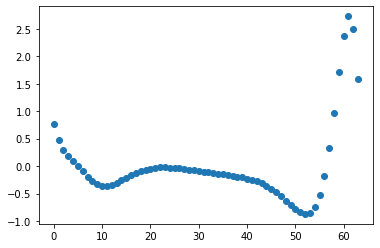

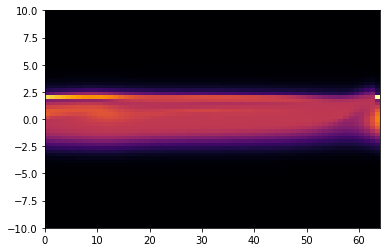

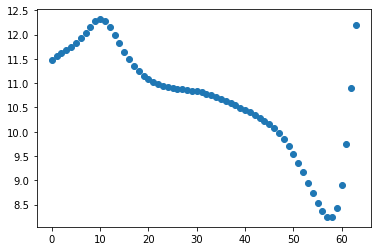

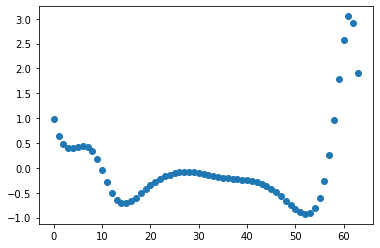

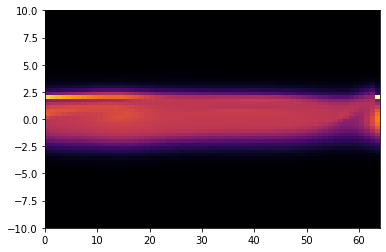

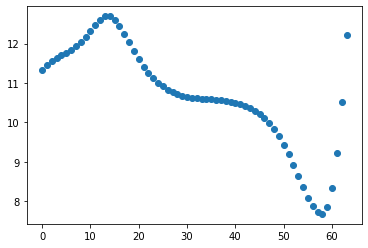

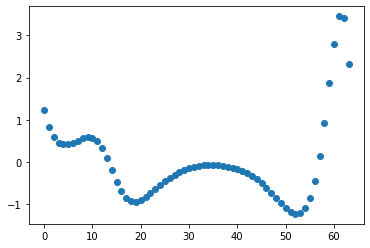

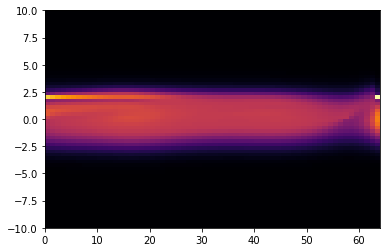

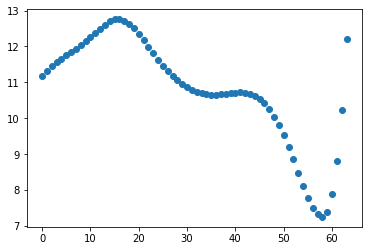

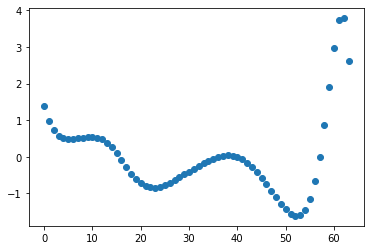

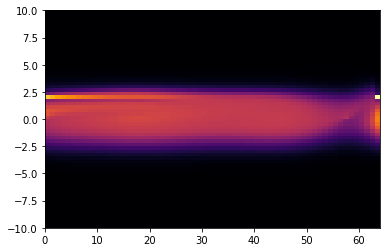

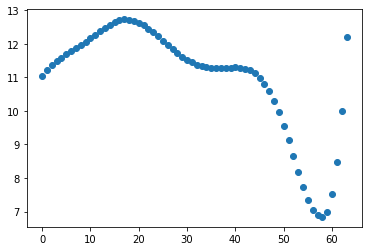

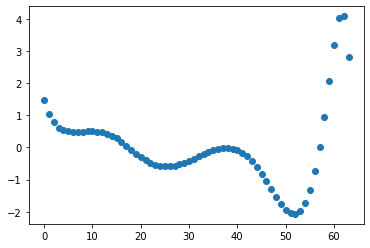

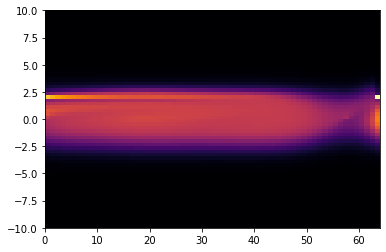

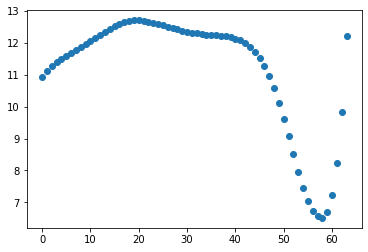

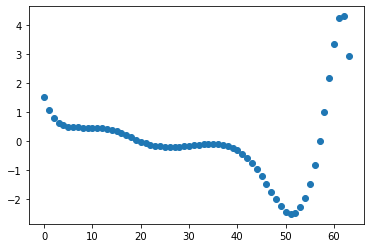

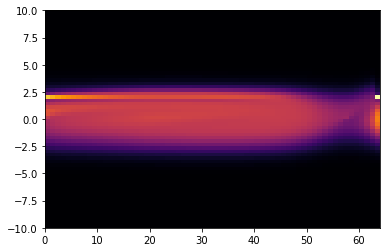

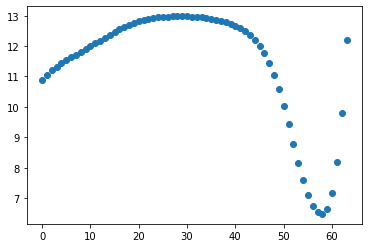

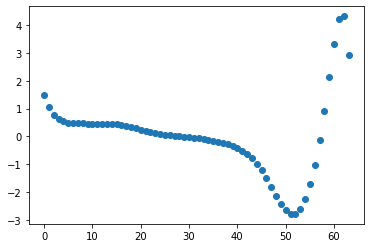

In [71]:
nx = 64
nv = 64
maxiter = 3000
maxiter_jacobi = 30
dt = 0.01
dx = 0.1
vmin = -10
vmax = 10
vth = 0.2*vmax

f = np.zeros((nx, nv))
#f[0,int(nv*np.clip(np.random.normal(0.6,0.1),0.5,1))] = 1
v = np.linspace(vmin, vmax, nv)
dv = np.abs(v[1] - v[0])
A = laplace(nx)


for i in range(nv):
        f[:, i] = np.exp(-v[i]**2/vth**2)
        
f[:,int(nv*0.6)] += 1 + np.random.uniform(0,0.1, nx)


for it in range(maxiter):
    #f[0,int(nv*np.clip(np.random.normal(0.55,0.01),0.5,1))-1] += 1
    #f[-2,int(nv*np.clip(np.random.normal(0.45,0.01),0,0.5))-1] += 1
    
    for i in range(nx-1):
        for j in range(nv-1):
            if v[j] > 0:
                f[i,j] = f[i,j] - dt/dx*(f[i,j]*v[j] - f[i-1,j]*v[j])
            else:
                f[i,j] = f[i,j] - dt/dx*(f[i+1,j]*v[j] - f[i,j]*v[j])

    rho = -1*np.sum(f, axis=1)
    rho = rho + np.mean(rho)

    phi = jacobi(A, rho, N=10)

    # Calculate electric field
    E = - gradient(nx)@phi

    for i in range(nx-1):
        for j in range(nv-1):
            if E[i] > 0:
                f[i,j] = f[i,j] - dt/dv*(f[i,j] - f[i,j-1])*E[i]
            else:
                f[i,j] = f[i,j] - dt/dv*(f[i,j+1] - f[i,j])*E[i]
    if it%100==0:
        plt.imshow(f.T, cmap="inferno",aspect="auto", origin="lower", extent=[0, nx, vmin, vmax])
        plt.show()
        plt.plot(f.sum(axis=1), "o")
        plt.show()
        plt.plot(E, "o")
        plt.show()